In [4]:
import numpy as np
import cv2
import os
import pandas as pd
from imutils import paths
from tqdm import tqdm
from matplotlib import pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip 'drive/MyDrive/dataset/COVID/COVID-19_Radiography_Dataset.zip' -d COVID_DATASET

In [12]:
DATADIR = 'COVID_DATASET'
IMG_SIZE_W = 256
IMG_SIZE_H = 256

In [13]:
#CATEGORIES = ["COVID", "Lung_Opacity","Normal","ViralPneumonia"]
CATEGORIES = ["COVID","Normal"]

In [6]:
!pip install -q keras-unet

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras_unet.models import custom_unet
from keras_unet.metrics import iou

model = tf.keras.models.load_model("drive/MyDrive/colab/model.h5",custom_objects={"iou": iou})

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [9]:
import random

training_data = []
for category in CATEGORIES:
        path = os.path.join(DATADIR,category)  # 
        class_num = CATEGORIES.index(category)  #
        for img in tqdm(os.listdir(path)):
            image = cv2.imread(os.path.join(path,img))  # convert a array
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            image = cv2.resize(image, (IMG_SIZE_W, IMG_SIZE_H))

            img_size = 128
            resized_shape = (img_size,img_size)
            offset = (0, 0)

            img_resized = cv2.resize(image, resized_shape).astype(np.uint8)
            img_padded = np.zeros((img_size, img_size), dtype=np.uint8)
            img_padded[
                offset[0] : (offset[0] + resized_shape[0]), offset[1] : (offset[1] + resized_shape[1])
            ] = img_resized

            random_img = img_padded
            random_img_2 = np.expand_dims(np.expand_dims(random_img, axis=0), axis=3)
            mask = model.predict(random_img_2)[0][:,:,0] > 0.5
            result = cv2.bitwise_and(random_img, random_img, mask=mask.astype(np.uint8))
            training_data.append([result, class_num])  # agregamos al trainnig_data

##
random.shuffle(training_data)

100%|██████████| 3200/3200 [05:39<00:00,  9.41it/s]


0


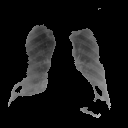

(128, 128)


In [ ]:
from google.colab.patches import cv2_imshow
i = 600
print(training_data[i][1])
cv2_imshow(training_data[i][0])
print(training_data[4][0].shape)

In [34]:
X = []
y = []
for features,label in training_data:
    X.append(features)
    y.append(label)

In [35]:
X = np.array(X).reshape(-1, 128,128, 1) #ultimo digito cantidad de canales
#Estandarizacion
X  = (X - np.mean(X)) / np.std(X)
y = np.array(y)
classes = np.unique(y)
nClasses = len(classes)
print('Output classes : ', classes)
print(X.shape, y.shape)

Output classes :  [0 1]
(6600, 128, 128, 1) (6600,)


In [36]:
from tensorflow.keras.utils import to_categorical
train_Y_one_hot = to_categorical(y)
#test_Y_one_hot = to_categorical(test_y)

In [37]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label  = train_test_split(X, train_Y_one_hot, test_size=0.2, random_state=13)

train_X = train_X.astype('float32')
valid_X = valid_X.astype('float32')

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU


modelCov = Sequential()
modelCov.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(128,128,1),padding='same'))
modelCov.add(LeakyReLU(alpha=0.1))
modelCov.add(MaxPooling2D((2, 2),padding='same'))
modelCov.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
modelCov.add(LeakyReLU(alpha=0.1))
modelCov.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
modelCov.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
modelCov.add(LeakyReLU(alpha=0.1))                  
modelCov.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
modelCov.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
modelCov.add(LeakyReLU(alpha=0.1))                  
modelCov.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
modelCov.add(Dropout(0.4))
modelCov.add(Flatten())
modelCov.add(Dense(64, activation='relu'))
modelCov.add(LeakyReLU(alpha=0.1))              
modelCov.add(Dropout(0.3))
modelCov.add(Dense(nClasses, activation='softmax'))

In [47]:
modelCov.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [48]:
batch_size = 32
epochs = 9

In [49]:
conv_train = modelCov.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/9
165/165 [==============================] - 9s 51ms/step - loss: 0.5209 - accuracy: 0.7407 - val_loss: 0.3889 - val_accuracy: 0.8159
Epoch 2/9
165/165 [==============================] - 8s 47ms/step - loss: 0.4003 - accuracy: 0.8134 - val_loss: 0.3335 - val_accuracy: 0.8576
Epoch 3/9
165/165 [==============================] - 8s 47ms/step - loss: 0.3475 - accuracy: 0.8432 - val_loss: 0.3243 - val_accuracy: 0.8561
Epoch 4/9
165/165 [==============================] - 8s 47ms/step - loss: 0.3185 - accuracy: 0.8553 - val_loss: 0.2933 - val_accuracy: 0.8780
Epoch 5/9
165/165 [==============================] - 8s 47ms/step - loss: 0.2858 - accuracy: 0.8759 - val_loss: 0.2927 - val_accuracy: 0.8712
Epoch 6/9
165/165 [==============================] - 8s 48ms/step - loss: 0.2672 - accuracy: 0.8826 - val_loss: 0.2948 - val_accuracy: 0.8705
Epoch 7/9
165/165 [==============================] - 8s 51ms/step - loss: 0.2381 - accuracy: 0.8947 - val_loss: 0.3452 - val_accuracy: 0.8583
Epoch 

In [19]:
test_eval = modelCov.evaluate(valid_X, valid_label, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

NameError: ignored

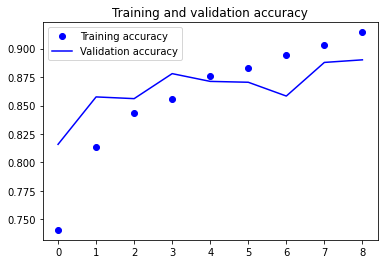

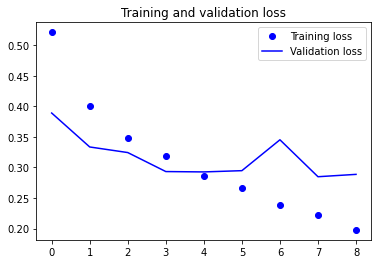

In [51]:
accuracy = conv_train.history['accuracy']
val_accuracy = conv_train.history['val_accuracy']
loss = conv_train.history['loss']
val_loss = conv_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [52]:
modelCov.save('covid_detection_model.h5')


In [7]:
modelCov = tf.keras.models.load_model("covid_detection_model.h5")

In [9]:
def process_image(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (IMG_SIZE_W, IMG_SIZE_H))
    img_size = 128
    resized_shape = (img_size,img_size)
    offset = (0, 0)

    img_resized = cv2.resize(image, resized_shape).astype(np.uint8)
    img_padded = np.zeros((img_size, img_size), dtype=np.uint8)
    img_padded[
        offset[0] : (offset[0] + resized_shape[0]), offset[1] : (offset[1] + resized_shape[1])
    ] = img_resized

    random_img = img_padded
    random_img_2 = np.expand_dims(np.expand_dims(random_img, axis=0), axis=3)
    mask = model.predict(random_img_2)[0][:,:,0] > 0.5
    result = cv2.bitwise_and(random_img, random_img, mask=mask.astype(np.uint8))
    return result

In [10]:
normalTestImg = []
covidTestImg = []

DATADIR = 'drive/MyDrive/dataset/COVID'
path = os.path.join(DATADIR,'NormalTest')  
for img in tqdm(os.listdir(path)):
  image = cv2.imread(os.path.join(path,img))  # convert a array
  #normalTestImg.append(process_image(image))
  normalTestImg.append(image)
print(len(normalTestImg))

DATADIR = 'drive/MyDrive/dataset/COVID'
path = os.path.join(DATADIR,'COVID_test')  
for img in tqdm(os.listdir(path)):
  image = cv2.imread(os.path.join(path,img))  # convert a array
  #covidTestImg.append(process_image(image))
  covidTestImg.append(image)
print(len(covidTestImg))

100%|██████████| 201/201 [00:02<00:00, 81.36it/s] 


201


100%|██████████| 216/216 [00:02<00:00, 76.63it/s]

216


COVID Positivo: 0.000016
COVID Negativo: 0.999984


Text(0.5, 1.0, 'Imagen procesada')

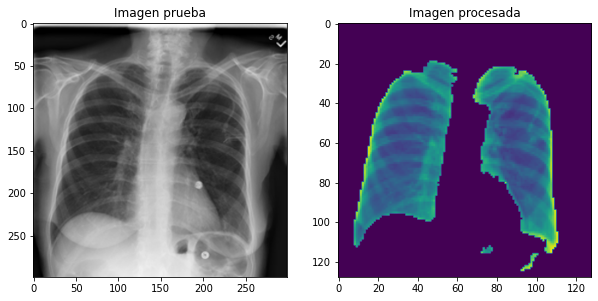

In [35]:
#@title Visualizando Data Pruebas COVID Negativo{ run: "auto" }
idx = 43 #@param {type:"slider", min:0, max:201, step:1}
#display(Image(normalTestImg[idx].tobytes()))
procc_image = process_image(normalTestImg[idx])
test = np.array(procc_image).reshape(-1, 128,128, 1)
test  = (test - np.mean(test)) / np.std(test)
result = modelCov.predict(test)

print('COVID Positivo:',format(result[0][0], '3f'))
print('COVID Negativo:', format(result[0][1], '3f') )

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(normalTestImg[idx])
ax1.set_title('Imagen prueba')

ax1 = fig.add_subplot(1,2,2)
ax1.imshow(procc_image)
ax1.set_title('Imagen procesada')

In [16]:
totalCorrecto = 0
for img in normalTestImg:
  procc_image = process_image(img)
  test = np.array(procc_image).reshape(-1, 128,128, 1)
  test  = (test - np.mean(test)) / np.std(test)
  result = modelCov.predict(test)
  if(result[0][1] > result[0][0]):
    totalCorrecto = totalCorrecto + 1
print('total COVID negativo: ',len(normalTestImg))
print('total correcto COVID negativo: ',totalCorrecto)#201

total COVID negativo:  201
total correcto COVID negativo:  147


In [15]:
totalCorrecto = 0
for img in covidTestImg:
  procc_image = process_image(img)
  test = np.array(procc_image).reshape(-1, 128,128, 1)
  test  = (test - np.mean(test)) / np.std(test)
  result = modelCov.predict(test)
  if(result[0][1] < result[0][0]):
    totalCorrecto = totalCorrecto + 1
print('total COVID negativo: ',len(covidTestImg))
print('total correcto COVID positivo: ',totalCorrecto)#201

total COVID negativo:  216
total correcto COVID positivo:  193


COVID Positivo: 1.000000
COVID Negativo: 0.000000


Text(0.5, 1.0, 'Imagen procesada')

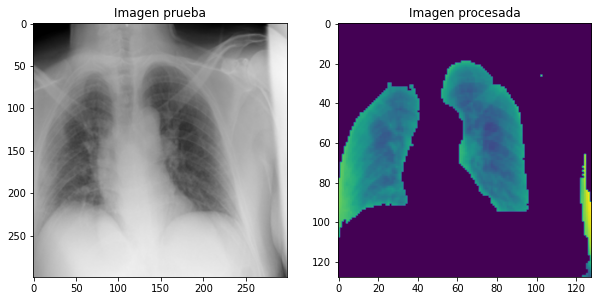

In [34]:
#@title Visualizando Data Prueba COVID Positivo{ run: "auto" }
idx = 16 #@param {type:"slider", min:0, max:216, step:1}
#display(Image(normalTestImg[idx].tobytes()))
procc_image = process_image(covidTestImg[idx])
test = np.array(procc_image).reshape(-1, 128,128, 1)
test  = (test - np.mean(test)) / np.std(test)
result = modelCov.predict(test)

print('COVID Positivo:',format(result[0][0], '3f'))
print('COVID Negativo:', format(result[0][1], '3f') )

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(covidTestImg[idx])
ax1.set_title('Imagen prueba')

ax1 = fig.add_subplot(1,2,2)
ax1.imshow(procc_image)
ax1.set_title('Imagen procesada')